In [ ]:
# default_exp data.transforms

In [ ]:
# hide 
import sys
sys.path.append('..')
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.all import *
# from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot

In [ ]:
from nbdev.showdoc import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [ ]:
# export
class NormalizeTS(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self,):
        self.m, self.s = 0, 0
    def encodes(self, o): 
        self.m, self.s = torch.mean(o[0],-1,keepdim=True), o[0].std(-1,keepdim=True)+1e-7 
        return Tuple([(o[i]-self.m)/self.s for i in range(len(o))])
    
    def decodes(self, o): 
        return Tuple([o[i]*self.s+self.m for i in range(len(o))])
        

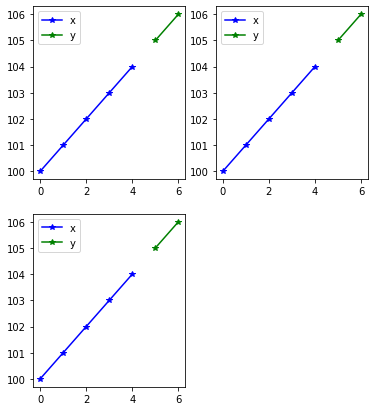

In [ ]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
ints = L( np.arange(7)[None,:]*1+100, np.arange(8)[None,:]*100+1,).map(tensor)
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=16, after_batch=NormalizeTS(), num_workers = 1)
for o in dl:
    test_close(o[0].mean(),0)
    test_close(o[0].std(-1),1)
    test_eq(type(o),Tuple)
    
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    test_eq(type(o_new),Tuple)
    
test_eq(type(dl.one_batch()),Tuple)

dl.show_batch()

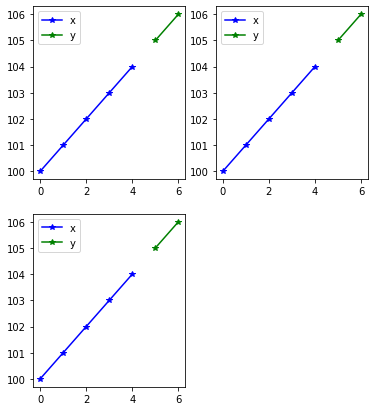

In [ ]:
# hide
if torch.cuda.is_available():
    from fastseq.data.load import *
    horizon,lookback = 2,5
    ints = L(tensor(o) for o in  [ np.arange(7)[None,:]*1+100, np.arange(8)[None,:]*100+1,])

    dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=16, after_batch=NormalizeTS(), num_workers = 1, device=torch.device('cuda'))    
    for o in dl:
        test_eq(o[0].is_cuda, True)
        dec_o = dl.after_batch[0].decode(o)
        test_eq(dec_o[0].is_cuda, True)  

    dl.show_batch()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 07_interpret.ipynb.
Converted 10_metrics.ipynb.
Converted 11_nbeats.metrics.ipynb.
Converted index.ipynb.
